In [46]:
import os
from astropy.io import fits
import astropy.units as u

import jax
import jax.numpy as jnp
from jax import jit

In [2]:
def load_data(redshift, file_number, model_name):
    # Define the base folder for all models
    parent_folder = "/feynman/work/dap/lcs/vt272285/data/sim_data/MassiveNus/"

    # Model parameters for each model
    models = {
        "model_one": {"mnv": 0.00000, "om": 0.30000, "As": 2.1000},
        "model_two": {"mnv": 0.09041, "om": 0.28447, "As": 2.1757},
        "model_three": {"mnv": 0.10000, "om": 0.30000, "As": 2.1000},
        "model_four": {"mnv": 0.11874, "om": 0.31434, "As": 2.0079},
    }

    # Dynamically generate paths for each model
    def generate_paths(models):
        redshifts = [0.5, 1.0, 1.5, 2.0, 2.5]
        for model_name, params in models.items():
            base_name = f"convergence_gal_mnv{params['mnv']:.5f}_om{params['om']:.5f}_As{params['As']:.4f}"
            paths = {z: os.path.join(parent_folder, f"{base_name}/Maps{int(z*10)}") for z in redshifts}
            models[model_name]["paths"] = paths

    # Populate model dictionaries with paths
    generate_paths(models)

    def get_file_name(model_name, redshift, file_number, models):
        try:
            model = models[model_name]
            folder_path = model["paths"][redshift]
            filename = f"WLconv_z{redshift:.2f}_{file_number:04d}r.fits"
            return os.path.join(folder_path, filename)
        except KeyError as e:
            raise ValueError(f"Missing data: {e}")

    try:
        # model_name = "model_one"
        # redshift = 1.5  #[0.5, 1.0, 1.5, 2.0, 2.5]
        # file_number = 100 #from 0 til 9999
        full_file_path = get_file_name(model_name, redshift, file_number, models)
        print(full_file_path)
    except ValueError as err:
        print(err)

    with fits.open(full_file_path) as hdu:
        data = hdu[0].data
        angle_ = hdu[0].header["ANGLE"] * u.deg
    return data, angle_


data, angle_ = load_data(redshift=1.5, file_number=100,model_name="model_one")

/feynman/work/dap/lcs/vt272285/data/sim_data/MassiveNus/convergence_gal_mnv0.00000_om0.30000_As2.1000/Maps15/WLconv_z1.50_0100r.fits


In [3]:
def load_data(file_no):
    base_path = "/feynman/work/dap/lcs/vt272285/HOWLS/HOWLS_DATA/"
    fiducial = "SLICS_LCDM/"
    fiducial_path = base_path + fiducial + "kappa_noise_GalCatalog_LOS_cone" + str(file_no) + ".fits_s333" + str(file_no) + "_zmin0.0_zmax3.0_sys_3.fits_ks_nomask_shear.fits"
    full_file_path = fiducial_path
    try:
        with fits.open(full_file_path) as hdu:
            data = hdu[0].data
            data = data[0]
            angle_ =10 * u.deg
        return data, angle_
    except FileNotFoundError:
        print(f"File {full_file_path} not found.")
        return None
    
data, angle_ = load_data(file_no=75)

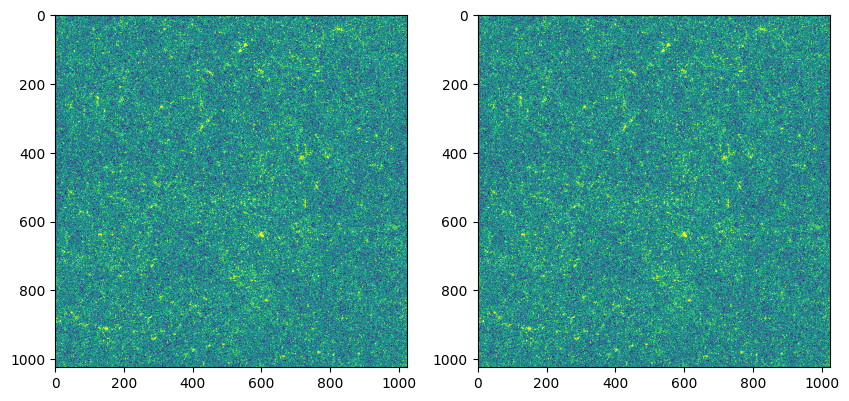

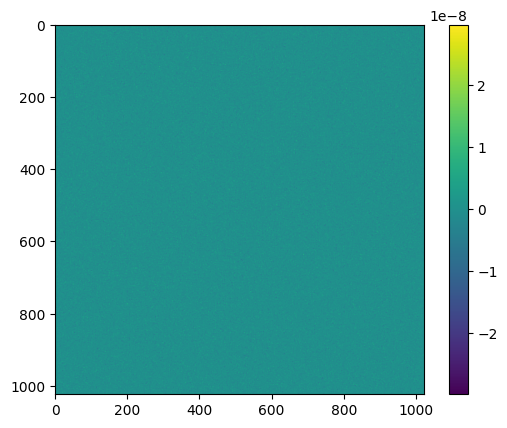

In [4]:
import numpy as np
from scipy.ndimage import convolve
import matplotlib.pyplot as plt

def box_filter_2d(matrix, scale):
    window_size = 2 ** scale
    filter_values = np.ones((window_size, window_size)) / (window_size ** 2)
    filtered_matrix = convolve(matrix, filter_values, mode='nearest')
    return filtered_matrix

def box_wavelet_transform_2d(matrix, max_scale):
    coefficients = []
    c = matrix
    for i in range(1, max_scale + 1):
        ci = box_filter_2d(c, i)
        wi = c - ci
        coefficients.append(wi)
        c = ci
    return c, coefficients

def reconstruct_signal_2d(cJ, coefficients):
    c0 = cJ
    for wi in coefficients[::-1]:
        c0 += wi
    return c0

c0 = data
max_scale = 6

cJ, coefficients = box_wavelet_transform_2d(c0, max_scale)
reconstructed_c0 = reconstruct_signal_2d(cJ, coefficients)

plt.figure(figsize=(10,5))
vmin = -0.1
vmax = -vmin
plt.subplot(1,2,1)
plt.imshow(data, vmin=vmin, vmax=vmax)

plt.subplot(1,2,2)
plt.imshow(reconstructed_c0, vmin=vmin, vmax=vmax)
plt.show()

plt.imshow(data-reconstructed_c0)
plt.colorbar()

In [5]:
# for i in range(len(coefficients)):
#     plt.imshow(coefficients[i])
#     plt.colorbar()
#     plt.show()

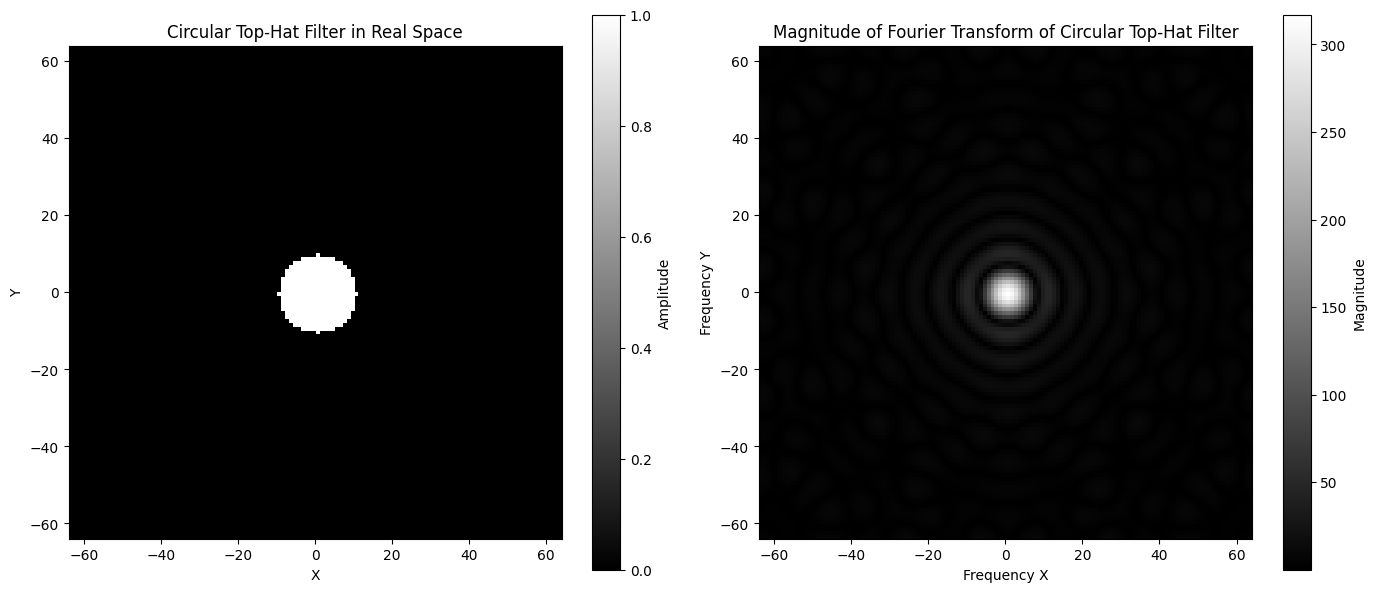

In [6]:
from scipy.fft import fft2, fftshift

def circular_top_hat_2d(radius, size):
    center = size // 2
    Y, X = np.ogrid[:size, :size]
    distance_from_center = np.sqrt((X - center)**2 + (Y - center)**2)
    top_hat_filter = (distance_from_center <= radius).astype(float)
    return top_hat_filter

# Parameters
radius = 10
size = 128

# Create the top-hat filter in real space
top_hat_filter = circular_top_hat_2d(radius, size)

# Compute the Fourier transform of the filter
top_hat_filter_ft = fft2(top_hat_filter)
top_hat_filter_ft_shifted = fftshift(top_hat_filter_ft)  # Shift zero frequency component to the center
top_hat_filter_ft_magnitude = np.abs(top_hat_filter_ft_shifted)  # Get magnitude

# Plotting the circular top-hat filter in real space
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.imshow(top_hat_filter, cmap='gray', extent=[-size//2, size//2, -size//2, size//2])
plt.title('Circular Top-Hat Filter in Real Space')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(label='Amplitude')

# Plotting the magnitude of the Fourier transform
plt.subplot(1, 2, 2)
plt.imshow(top_hat_filter_ft_magnitude, cmap='gray', extent=[-size//2, size//2, -size//2, size//2])
plt.title('Magnitude of Fourier Transform of Circular Top-Hat Filter')
plt.xlabel('Frequency X')
plt.ylabel('Frequency Y')
plt.colorbar(label='Magnitude')

plt.tight_layout()
plt.show()


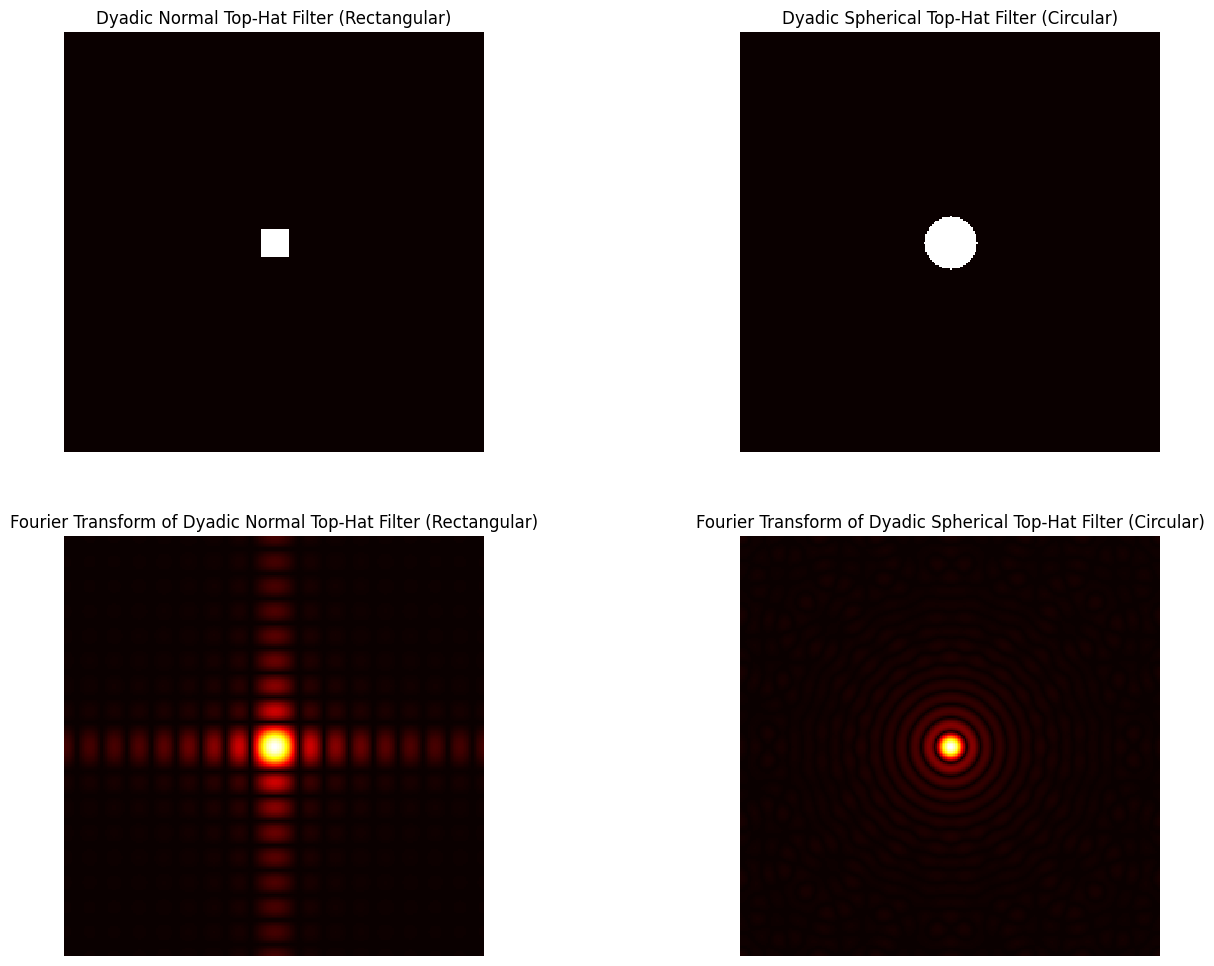

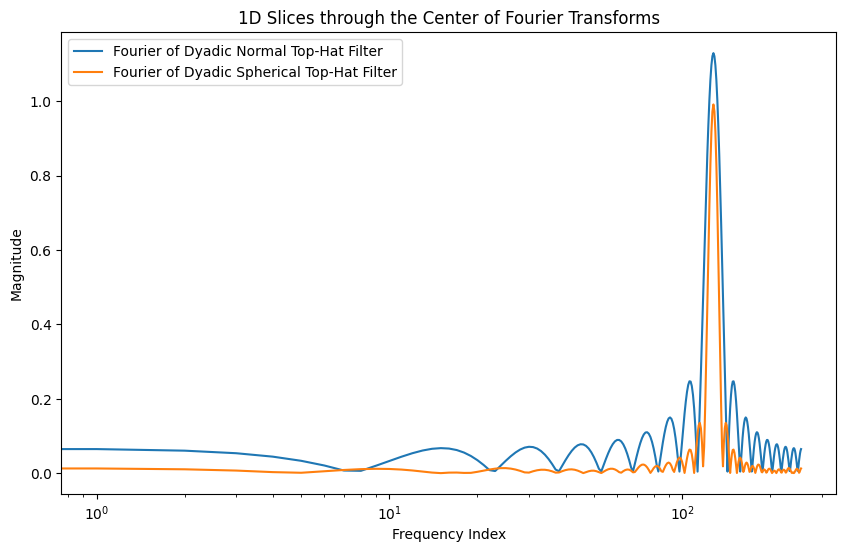

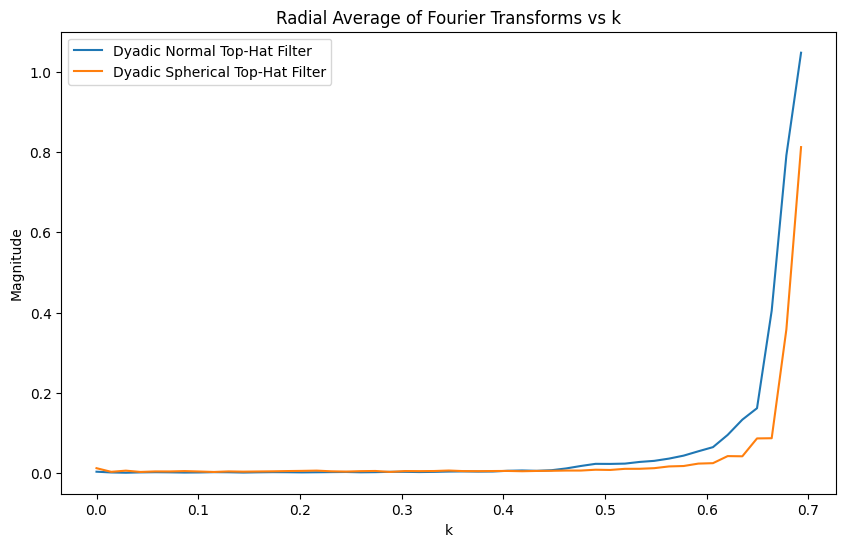

In [63]:
def dyadic_normal_top_hat_filter(scale_exp, size):
    """
    Creates a 2D normal top-hat filter with given dyadic scale and size.
    """
    scale = 2 ** scale_exp
    filter_size = size // 2
    top_hat = np.zeros((size, size))
    for i in range(-scale, scale + 1):
        for j in range(-scale, scale + 1):
            if abs(i) <= scale and abs(j) <= scale:
                top_hat[filter_size + i, filter_size + j] = 1 / (4 * scale * scale)
    return top_hat

def dyadic_spherical_top_hat_filter(scale_exp, size):
    """
    Creates a 2D spherical top-hat filter with given dyadic scale and size.
    """
    scale = 2 ** scale_exp
    filter_size = size // 2
    top_hat = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            r = np.sqrt((i - filter_size) ** 2 + (j - filter_size) ** 2)
            if r <= 2 * scale:
                top_hat[i, j] = 1 / (np.pi * (2 * scale) ** 2)
    return top_hat

def fourier_transform(filter_2d):
    """
    Computes the Fourier transform of a 2D filter and shifts the zero frequency component to the center.
    """
    f_transform = np.fft.fft2(filter_2d)
    f_transform_shifted = np.fft.fftshift(f_transform)
    magnitude_spectrum = np.abs(f_transform_shifted)
    return magnitude_spectrum

# Parameters
scale_exp = 3  # Example dyadic scale: 2^3 = 8
size = 256  # Ensuring size is sufficiently large

# Generate filters
dyadic_normal_top_hat = dyadic_normal_top_hat_filter(scale_exp, size)
dyadic_spherical_top_hat = dyadic_spherical_top_hat_filter(scale_exp, size)

# Compute Fourier transforms
fourier_dyadic_normal_top_hat = fourier_transform(dyadic_normal_top_hat)
fourier_dyadic_spherical_top_hat = fourier_transform(dyadic_spherical_top_hat)

# Plot filters and their Fourier transforms
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

ax[0, 0].imshow(dyadic_normal_top_hat, cmap='hot', interpolation='nearest')
ax[0, 0].set_title('Dyadic Normal Top-Hat Filter (Rectangular)')
ax[0, 0].axis('off')

ax[0, 1].imshow(dyadic_spherical_top_hat, cmap='hot', interpolation='nearest')
ax[0, 1].set_title('Dyadic Spherical Top-Hat Filter (Circular)')
ax[0, 1].axis('off')

ax[1, 0].imshow(np.log(1 + fourier_dyadic_normal_top_hat), cmap='hot', interpolation='nearest')
ax[1, 0].set_title('Fourier Transform of Dyadic Normal Top-Hat Filter (Rectangular)')
ax[1, 0].axis('off')

ax[1, 1].imshow(np.log(1 + fourier_dyadic_spherical_top_hat), cmap='hot', interpolation='nearest')
ax[1, 1].set_title('Fourier Transform of Dyadic Spherical Top-Hat Filter (Circular)')
ax[1, 1].axis('off')

plt.show()

def plot_1d_slices(fourier_filter, title):
    """
    Plots the 1D slice through the center of the Fourier transform.
    """
    center = fourier_filter.shape[0] // 2
    slice_1d = fourier_filter[center, :]
    
    plt.plot(slice_1d, label=title)

# Plot 1D slices
plt.figure(figsize=(10, 6))
plot_1d_slices(fourier_dyadic_normal_top_hat[], 'Fourier of Dyadic Normal Top-Hat Filter')
plot_1d_slices(fourier_dyadic_spherical_top_hat, 'Fourier of Dyadic Spherical Top-Hat Filter')
plt.xscale("log")
plt.title('1D Slices through the Center of Fourier Transforms')
plt.xlabel('Frequency Index')
plt.ylabel('Magnitude')
plt.legend()
plt.show()



In [73]:
import scipy.stats as stats

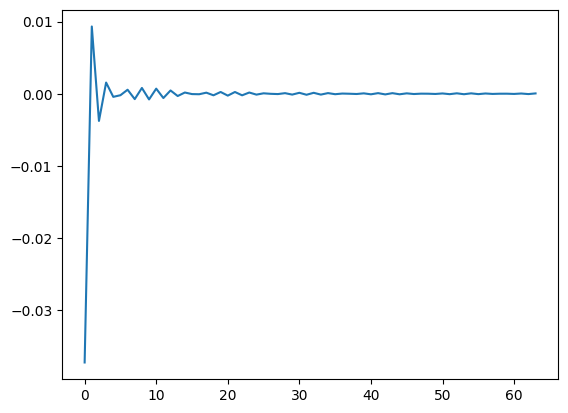

In [81]:
def get_pk(fourier_image):
    npix = size 
    kfreq = np.fft.fftfreq(npix) * npix
    kfreq2D = np.meshgrid(kfreq, kfreq)
    knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)
    knrm = knrm.flatten()
    fourier_amplitudes = fourier_image #np.abs(fourier_image)**2
    fourier_amplitudes = fourier_amplitudes.flatten()
    knrm = knrm.flatten()
    fourier_amplitudes = fourier_amplitudes.flatten()
    kbins = np.arange(0.5, npix//2+1, 2.)
    kvals = 0.5 * (kbins[1:] + kbins[:-1])
    Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                        statistic = "mean",
                                        bins = kbins)
    Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
    plt.plot(kvals, Abins)
    return kvals, Abins

fourier_normal_top_hat = fourier_transform(dyadic_normal_top_hat)
fourier_spherical_top_hat = fourier_transform(dyadic_spherical_top_hat)
def analytic_spherical_top_hat(k, R):
    """
    Analytic Fourier transform of a spherical top-hat filter.
    """
    return 2 * j1(k * R) / (k * R)

# k_th, pk_th = get_pk(fourier_normal_top_hat)
# k_sth, pk_sth = get_pk(fourier_spherical_top_hat)
plt.plot(analytic_spherical_top_hat(k_th, 2**3))

(256, 256)


/tmp/ipykernel_3694077/325135376.py:92: RuntimeWarning: invalid value encountered in divide
  return 2 * j1(k * R) / (k * R)


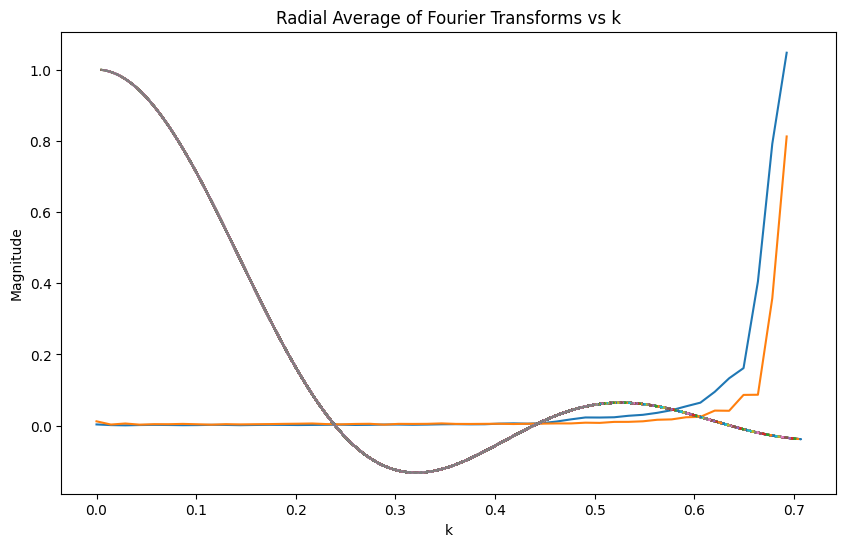

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j1

# Redefine functions as the code execution state was reset

def dyadic_normal_top_hat_filter(scale_exp, size):
    """
    Creates a 2D normal top-hat filter with given dyadic scale and size.
    """
    scale = 2 ** scale_exp
    filter_size = size // 2
    top_hat = np.zeros((size, size))
    for i in range(-scale, scale + 1):
        for j in range(-scale, scale + 1):
            if abs(i) <= scale and abs(j) <= scale:
                top_hat[filter_size + i, filter_size + j] = 1 / (4 * scale * scale)
    return top_hat

def dyadic_spherical_top_hat_filter(scale_exp, size):
    """
    Creates a 2D spherical top-hat filter with given dyadic scale and size.
    """
    scale = 2 ** scale_exp
    filter_size = size // 2
    top_hat = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            r = np.sqrt((i - filter_size) ** 2 + (j - filter_size) ** 2)
            if r <= 2 * scale:
                top_hat[i, j] = 1 / (np.pi * (2 * scale) ** 2)
    return top_hat

def fourier_transform(filter_2d):
    """
    Computes the Fourier transform of a 2D filter and shifts the zero frequency component to the center.
    """
    f_transform = np.fft.fft2(filter_2d)
    f_transform_shifted = np.fft.fftshift(f_transform)
    magnitude_spectrum = np.abs(f_transform_shifted)
    return magnitude_spectrum

def compute_k_values(size):
    """
    Computes the k values for a 2D Fourier transform.
    """
    kx = np.fft.fftfreq(size)
    ky = np.fft.fftfreq(size)
    kx, ky = np.meshgrid(kx, ky)
    k_values = np.sqrt(kx**2 + ky**2)
    return k_values

def radial_average(fourier_filter, k_values, num_bins=50):
    """
    Computes the radial average of the Fourier transform based on k values.
    """
    k_max = np.max(k_values)
    bins = np.linspace(0, k_max, num_bins)
    radial_profile = np.zeros(num_bins-1)
    
    for i in range(num_bins-1):
        mask = (k_values >= bins[i]) & (k_values < bins[i+1])
        if np.any(mask):
            radial_profile[i] = np.mean(fourier_filter[mask])
        
    return bins[:-1], radial_profile


# Parameters
scale_exp = 3  # Example dyadic scale: 2^3 = 8
size = 256  # Ensuring size is sufficiently large

# Generate filters
dyadic_normal_top_hat = dyadic_normal_top_hat_filter(scale_exp, size)
dyadic_spherical_top_hat = dyadic_spherical_top_hat_filter(scale_exp, size)

# Compute Fourier transforms
fourier_dyadic_normal_top_hat = np.abs(fourier_transform(dyadic_normal_top_hat))
fourier_dyadic_spherical_top_hat = fourier_transform(dyadic_spherical_top_hat)
print(fourier_dyadic_normal_top_hat.shape)
# Compute k values
k_values = compute_k_values(size)

# Compute radial averages
k_bins, radial_normal_top_hat = radial_average(fourier_dyadic_normal_top_hat, k_values)
_, radial_spherical_top_hat = radial_average(fourier_dyadic_spherical_top_hat, k_values)

def analytic_spherical_top_hat(k, R):
    """
    Analytic Fourier transform of a spherical top-hat filter.
    """
    return 2 * j1(k * R) / (k * R)

# Parameters
R = 2 ** (scale_exp + 1)  # Radius of the filter in dyadic scale

# Compute k values for analytic form
k_analytic = k_values
analytic_transform = analytic_spherical_top_hat(k_analytic, R)

# Plot radial averages and analytic transform
plt.figure(figsize=(10, 6))
plt.plot(k_bins, radial_normal_top_hat, label='Dyadic Normal Top-Hat Filter')
plt.plot(k_bins, radial_spherical_top_hat, label='Computed Dyadic Spherical Top-Hat Filter')
plt.plot(k_analytic, analytic_transform, label='Analytic Dyadic Spherical Top-Hat Filter', linestyle='dashed')

plt.title('Radial Average of Fourier Transforms vs k')
plt.xlabel('k')
plt.ylabel('Magnitude')
# plt.legend()
plt.show()


1 -7.5756307e-06
2 -3.0391204e-06


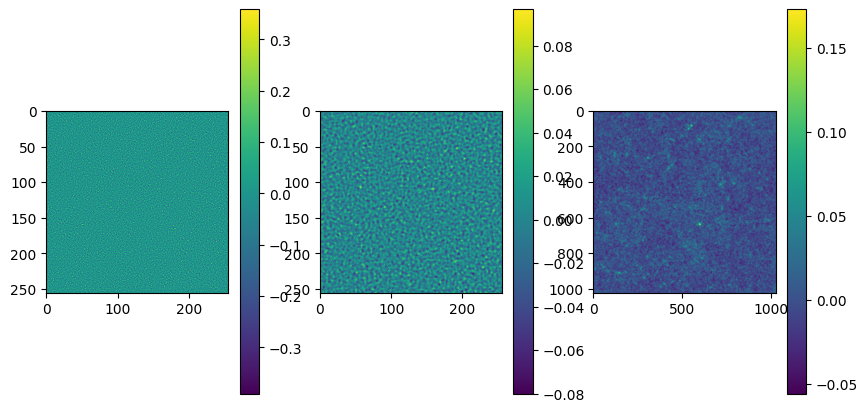

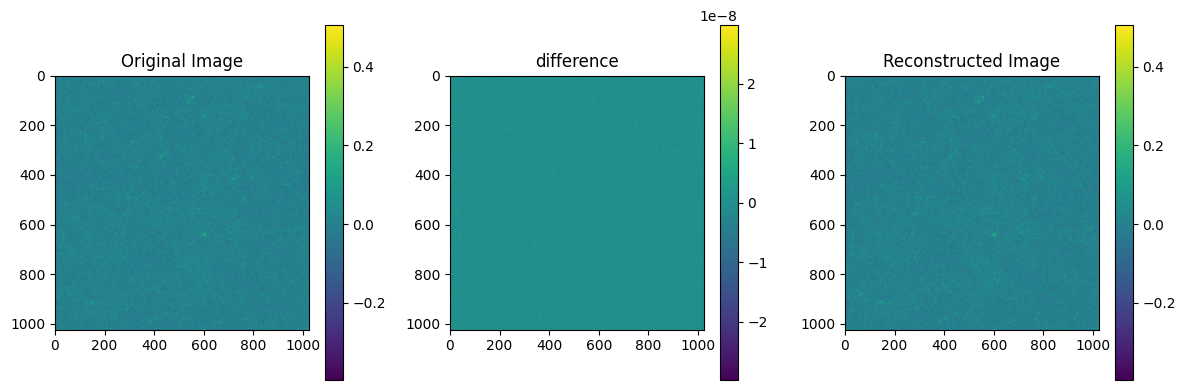

In [47]:
def top_hat_filter_2d(scale, size):
    radius = 2 ** scale
    center = size // 2
    Y, X = jnp.ogrid[:size, :size]
    distance_from_center = jnp.sqrt((X - center)**2 + (Y - center)**2)
    top_hat_filter = (distance_from_center <= radius).astype(float)
    return top_hat_filter / jnp.sum(top_hat_filter)

@jit
def apply_filter(image, filter_kernel):
    filter_kernel = filter_kernel[:, :, None, None]
    image = image[None, :, :, None]
    result = jax.lax.conv_general_dilated(
        image, filter_kernel,
        window_strides=(1, 1),
        padding='SAME',
        dimension_numbers=('NHWC', 'HWIO', 'NHWC')
    )
    return result[0, :, :, 0]

# @jit
def wavelet_decomposition(image, max_scale):
    size = image.shape[0]
    coefficients = []
    c = image
    for i in range(1, max_scale + 1):
        filter_kernel = top_hat_filter_2d(i, size)
        ci = apply_filter(c, filter_kernel)
        wi = c - ci
        print(i, jnp.mean(wi))
        coefficients.append(wi)
        c = ci
    return c, coefficients

@jit
def reconstruct_image(cJ, coefficients):
    c0 = cJ
    for wi in coefficients:
        c0 += wi
    return c0


image = jnp.array(data[::, ::], dtype=jnp.float32)  # Ensure the correct dtype
max_scale = 2
cJ, coeffs = wavelet_decomposition(image, max_scale)
reconstructed_image = reconstruct_image(cJ, coeffs)

fig, axs = plt.subplots(1, max_scale+1, figsize=(10,5))

for i in range(max_scale):
    mappable = axs[i].imshow(coefficients[i])
    plt.colorbar(mappable)
 
mappable = axs[-1].imshow(cJ)
plt.colorbar(mappable)

# Plotting the results
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Original Image')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(image-reconstructed_image)
plt.colorbar()
plt.title("difference")

plt.subplot(1, 3, 3)
plt.imshow(reconstructed_image)
plt.title('Reconstructed Image')
plt.colorbar()

plt.tight_layout()
plt.show()